In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

# Deep Learning Imports
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image

# Setup
np.random.seed(42)
sns.set_style("darkgrid")

2025-12-30 13:18:36.287481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767100716.463945      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767100716.517112      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767100716.969232      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767100716.969274      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767100716.969276      55 computation_placer.cc:177] computation placer alr

In [2]:
# Define Dataset Path (Adjust if needed for Kaggle)
dataset_path = Path('/kaggle/input/spacenet-an-optimally-distributed-astronomy-data')

# 1. Gather all file paths
def get_image_paths(root_path):
    image_paths = []
    labels = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tif']:
        for path in root_path.rglob(ext):
            image_paths.append(str(path))
            labels.append(path.parent.name)
    return pd.DataFrame({'path': image_paths, 'label': labels})

df = get_image_paths(dataset_path)

# 2. Convert text labels (Star, Galaxy) to numbers (0, 1)
# XGBoost requires numbers as targets
label_map = {label: i for i, label in enumerate(df['label'].unique())}
df['label_code'] = df['label'].map(label_map)

# 3. Split Data (80% Train, 20% Test)
# Stratify ensures we have equal mix of stars/galaxies in both sets
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=42
)

print(f"Training Samples: {len(train_df)}")
print(f"Testing Samples: {len(test_df)}")
print(f"Classes: {label_map}")

Training Samples: 10259
Testing Samples: 2565
Classes: {'planet': 0, 'galaxy': 1, 'black hole': 2, 'asteroid': 3, 'comet': 4, 'star': 5, 'constellation': 6, 'nebula': 7}


In [4]:
# Load Pretrained ResNet50 (No classification layer)
print("Loading ResNet50...")
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_features(dataframe):
    features = []
    labels = []
    
    print("Extracting features...")
    for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        img_path = row['path']
        try:
            # Load & Resize
            img = image.load_img(img_path, target_size=(224, 224))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x) # Normalize for ResNet
            
            # Extract Feature Vector
            feat = model.predict(x, verbose=0).flatten()
            
            features.append(feat)
            labels.append(row['label_code'])
        except Exception as e:
            continue # Skip bad images

    return np.array(features), np.array(labels)

# Extract for BOTH Train and Test sets
print("--- Processing Training Data ---")
X_train, y_train = extract_features(train_df)

print("--- Processing Testing Data ---")
X_test, y_test = extract_features(test_df)

print(f"Feature Vector Shape: {X_train.shape}") # Should be (N, 2048)

Loading ResNet50...
--- Processing Training Data ---
Extracting features...


100%|██████████| 10259/10259 [28:46<00:00,  5.94it/s]


--- Processing Testing Data ---
Extracting features...


100%|██████████| 2565/2565 [08:35<00:00,  4.97it/s]

Feature Vector Shape: (9171, 2048)


In [16]:
print("Training XGBoost Classifier...")

clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# Train the model
clf.fit(X_train, y_train)

print("Training Complete!")

Training XGBoost Classifier...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:54:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training Complete!


✅ Baseline Accuracy: 0.7536 (75.36%)

--- Classification Report ---
               precision    recall  f1-score   support

       planet       0.83      0.96      0.89       294
       galaxy       0.76      0.83      0.79       509
   black hole       0.87      0.67      0.76       131
     asteroid       0.80      0.84      0.82        57
        comet       0.83      0.58      0.68        83
         star       0.70      0.76      0.73       654
constellation       0.68      0.50      0.58       311
       nebula       0.79      0.75      0.77       238

     accuracy                           0.75      2277
    macro avg       0.78      0.74      0.75      2277
 weighted avg       0.75      0.75      0.75      2277



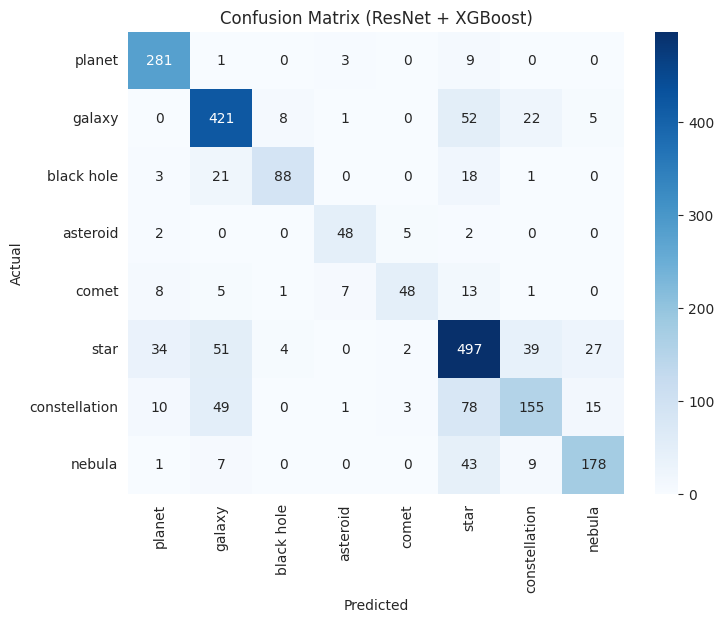

In [17]:
# Make Predictions
y_pred = clf.predict(X_test)

# Calculate Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"✅ Baseline Accuracy: {acc:.4f} ({acc*100:.2f}%)")

# Classification Report
# We need to reverse the label map to show names (Galaxy, Star) instead of 0, 1
inv_map = {v: k for k, v in label_map.items()}
target_names = [inv_map[i] for i in sorted(inv_map.keys())]

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion Matrix Plot
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (ResNet + XGBoost)')
plt.show()